# Applying Logistic regression to 2 layer QG
See `simple_run2.ipynb` and `rare_statistics.ipynb` for more details

## Modules import
First, setting the path and loading of some modules

In [9]:
import sys, os
sys.path.extend([os.path.abspath('../')])
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc
rc('font',**{'family':'serif','sans-serif':['Times'],'size':14})
import xarray as xr
np.random.seed(1234) # Initializing the random number generator (for reproducibility). -- Disable if needed.

from qgs.params.params import QgParams #Importing the model's modules
from qgs.integrators.integrator import RungeKuttaIntegrator, RungeKuttaTglsIntegrator
from qgs.functions.tendencies import create_tendencies
from qgs.plotting.util import std_plot

from qgs.diagnostics.streamfunctions import MiddleAtmosphericStreamfunctionDiagnostic # and diagnostics
from qgs.diagnostics.variables import VariablesDiagnostic
from qgs.diagnostics.multi import MultiDiagnostic

from qgs.diagnostics.temperatures import GroundTemperatureDiagnostic
from qgs.diagnostics.temperatures import MiddleAtmosphericTemperatureDiagnostic

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
#### Custom Metrics ######

class UnbiasedMetric(keras.metrics.Metric):
    def __init__(self, name, undersampling_factor=1, **kwargs):
        super().__init__(name=name, **kwargs)
        self.undersampling_factor = undersampling_factor
        self.r = tf.cast([0.5*np.log(undersampling_factor), -0.5*np.log(undersampling_factor)], tf.float32)

    
class MCCMetric(UnbiasedMetric): # This function is designed to produce confusion matrix during training each epoch
    def __init__(self, num_classes=2, threshold=None, undersampling_factor=1, name='MCC', **kwargs):
        '''
        Mathews correlation coefficient metric

        Parameters
        ----------
        num_classes : int, optional
            number of classes, by default 2
        threshold : float, optional
            If num_classes == 2 allows to choose a threshold over which to consider an event positive. If None the event is positive if it has probability higher than 0.5. By default None
        '''
        super().__init__(name=name, undersampling_factor=undersampling_factor, **kwargs) # handles base args (e.g., dtype)
        self.num_classes=num_classes
        self.threshold = threshold
        if self.num_classes != 2:
            raise NotImplementedError('MCC works only with 2 classes')
        self.total_cm = self.add_weight("total", shape=(num_classes,num_classes), initializer="zeros")
    
    def reset_states(self):
        for s in self.variables:
            s.assign(tf.zeros(shape=s.shape))
            
    def update_state(self, y_true, y_pred,sample_weight=None):
        self.total_cm.assign_add(self.confusion_matrix(y_true,y_pred))
        return self.total_cm
    
    @tf.autograph.experimental.do_not_convert
    def result(self):
        #return self.process_confusion_matrix()
        cm=self.total_cm
        
        #return cm
        TN = cm[0,0]
        FP = cm[0,1]
        FN = cm[1,0]
        TP = cm[1,1]
        MCC_den = ((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
        MCC = (TP * TN - FP *FN)/tf.sqrt(MCC_den)
        return tf.cond(MCC_den == 0, lambda: tf.constant(0, dtype=tf.float32), lambda: MCC)
    
    def confusion_matrix(self,y_true, y_pred): # Make a confusion matrix
        if self.undersampling_factor > 1 or self.threshold is not None:
            y_pred = keras.layers.Softmax()(y_pred + self.r) # apply shift of logits and softmax to convert to balanced probabilities
        if self.threshold is None:
            y_pred=tf.argmax(y_pred,1)
        else:
            y_pred = tf.cast(y_pred[:,1] > self.threshold, tf.int8)
        cm=tf.math.confusion_matrix(y_true,y_pred,dtype=tf.float32,num_classes=self.num_classes)
        return cm
    
    def fill_output(self,output):
        results=self.result()
        
class ConfusionMatrixMetric(UnbiasedMetric): # This function is designed to produce confusion matrix during training each epoch
    """
    A custom Keras metric to compute the running average of the confusion matrix
    """
    def __init__(self, num_classes, undersampling_factor=1, name='confusion_matrix', **kwargs):
        super().__init__(name=name, undersampling_factor=undersampling_factor, **kwargs) # handles base args (e.g., dtype)
        self.num_classes=num_classes
        self.total_cm = self.add_weight("total", shape=(num_classes,num_classes), initializer="zeros")
        
    def reset_states(self):
        for s in self.variables:
            s.assign(tf.zeros(shape=s.shape))
            
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.total_cm.assign_add(self.confusion_matrix(y_true,y_pred))
        return self.total_cm
        
    def result(self):
        #return self.process_confusion_matrix()
        cm=self.total_cm
        return cm
    
    def confusion_matrix(self,y_true, y_pred): # Make a confusion matrix
        if self.undersampling_factor > 1:
            y_pred = keras.layers.Softmax()(y_pred + self.r) # apply shift of logits and softmax to convert to balanced probabilities
        
        y_pred=tf.argmax(y_pred,1)
        cm=tf.math.confusion_matrix(y_true,y_pred,dtype=tf.float32,num_classes=self.num_classes)
        return cm
    
    def fill_output(self,output):
        results=self.result()

class BrierScoreMetric(UnbiasedMetric):
    def __init__(self, undersampling_factor=1, name='BrierScore', **kwargs):
        super().__init__(name=name, undersampling_factor=undersampling_factor, **kwargs)
        self.mse = keras.metrics.MeanSquaredError()
        self.my_metric = self.add_weight(name='BScore', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        _ = self.mse.update_state(y_true, keras.layers.Softmax()(y_pred + self.r))
        self.my_metric.assign(self.mse.result())

    def result(self):
        return self.my_metric

class UnbiasedCrossentropyMetric(UnbiasedMetric):

  def __init__(self, undersampling_factor=1, name='UnbiasedCrossentropy', **kwargs):
    super().__init__(name=name, undersampling_factor=undersampling_factor, **kwargs)
    self.my_metric = self.add_weight(name='CLoss', initializer='zeros')
    self.m = tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=True)

  def update_state(self, y_true, y_pred, sample_weight=None):
    #_ = self.m.update_state(tf.cast(y_true, 'int32'), y_pred)
    _ = self.m.update_state(y_true, y_pred+self.r) # the idea is to add the weight factor inside the logit so that we effectively change the probabilities
    self.my_metric.assign(self.m.result())
    
  def result(self):
    return self.my_metric


# same as above but less elegant
class CustomLoss(tf.keras.metrics.Metric):

  def __init__(self, r, name='CustomLoss', **kwargs):
    super().__init__(name=name, **kwargs)
    self.my_metric = self.add_weight(name='CLoss', initializer='zeros')
    self.r = r # undersampling_factor array (we expect the input as tf.cast(-0.5*np.log(undersampling_factor), 0.5*np.log(undersampling_factor))
    self.m = tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=True)


  def update_state(self, y_true, y_pred, sample_weight=None):
    #_ = self.m.update_state(tf.cast(y_true, 'int32'), y_pred)
    _ = self.m.update_state(y_true, y_pred+self.r) # the idea is to add the weight factor inside the logit so that we effectively change the probabilities
    self.my_metric.assign(self.m.result())
    
  def result(self):
    return self.my_metric

  """ 
  def reset_states(self):
    # The state of the metric will be reset at the start of each epoch.
    self.my_metric.assign(0.) 
  """

class UnbiasedCrossentropyLoss(keras.losses.SparseCategoricalCrossentropy):
    '''
    This is the same as the UnbiasedCrossentropyMetric but can be used as a loss
    '''
    def __init__(self, undersampling_factor=1, name='unbiased_crossentropy_loss'):
        super().__init__(from_logits=True, name=name)
        self.r = tf.cast([0.5*np.log(undersampling_factor), -0.5*np.log(undersampling_factor)], tf.float32)

    def __call__(self, y_true, y_pred, sample_weight=None):
        return super().__call__(y_true, y_pred + self.r)

class MyMetrics_layer(tf.keras.metrics.Metric):

  def __init__(self, name='MyMetrics_layer', **kwargs):
    super(MyMetrics_layer, self).__init__(name=name, **kwargs)
    self.my_metric = self.add_weight(name='my_metric1', initializer='zeros')
    self.m = tf.keras.metrics.SparseCategoricalAccuracy()


  def update_state(self, y_true, y_pred, sample_weight=None):
    _ = self.m.update_state(tf.cast(y_true, 'int32'), y_pred)
    self.my_metric.assign(self.m.result())
    
  def result(self):
    return self.my_metric

  def reset_states(self):
    # The state of the metric will be reset at the start of each epoch.
    self.my_metric.assign(0.)
"""
class CustomLoss(tf.keras.metrics.Metric):

  def __init__(self, name='custom_loss', **kwargs):
    super(CustomLoss, self).__init__(name=name, **kwargs)
    #self.custom_loss = self.add_weight(name='closs', initializer='zeros')
    self.scce=tf.keras.losses.SparseCategoricalCrossentropy()#from_logits=True), #If the predicted labels are not converted to a probability distribution by the last layer of the model (using sigmoid or softmax activation functions), we need to inform these t

  def update_state(self, y_true, y_pred, sample_weight=None):
    update_state_out = self.scce(y_true,y_pred)
    update_state_out = y_true.shape
    self.custom_loss.assign_add(update_state_out)

  def result(self):
    #return self.custom_loss
    return self.scce(y_true,y_pred)
"""

def create_Logistic(model_input_dim, regularizer='l2', regularizer_coef=1e-9):
    inputs = keras.Input(shape=model_input_dim) # Create a standard model (alternatively we can use our function my_create_logistic_model which builds a custom sequential model
    x = tf.keras.layers.Flatten(input_shape=model_input_dim)(inputs)
    if regularizer == 'none':
        outputs = tf.keras.layers.Dense(2)(x)
    elif regularizer == 'l2':
        outputs = tf.keras.layers.Dense(2, kernel_regularizer=regularizers.l2(regularizer_coef))(x)
    else:
        outputs = tf.keras.layers.Dense(2, kernel_regularizer=regularizers.l1(regularizer_coef))(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)   # alternatively we can write:     model = MyModel(inputs=inputs, outputs=outputs)
    return model

def make_checkpoint_callback(file_path, checkpoint_every=1):
    '''
    Creates a ModelCheckpoint callback
    Parameters
    ----------
    file_path : str
        path to the folder where the checkpoints will be stored. Can also have a format, for example <folder>/cp-{epoch:04d}.ckpt
    checkpoint_every : int or str, optional
        Examples:
        0: disabled
        5 or '5 epochs' or '5 e': every 5 epochs
        '100 batches' or '100 b': every 100 batches
        'best custom_loss': every time 'custom_loss' reaches a new minimum. 'custom_loss' must be in the list of metrics
    Returns
    -------
    keras.callbacks.ModelCheckpoint
    Raises
    ------
    ValueError
        If the system doesn't manage to interpret `checkpoint_every`
    '''
    ckpt_callback = None
    if checkpoint_every == 0: # no checkpointing
        pass
    elif checkpoint_every == 1: # save every epoch
        ckpt_callback = keras.callbacks.ModelCheckpoint(filepath=file_path, save_weights_only=True, verbose=1)
    elif isinstance(checkpoint_every, int): # save every `checkpoint_every` epochs 
        ckpt_callback = keras.callbacks.ModelCheckpoint(filepath=file_path, save_weights_only=True, verbose=1, period=checkpoint_every)
    elif isinstance(checkpoint_every, str): # parse string options
        if checkpoint_every[0].isnumeric():
            every, what = checkpoint_every.split(' ',1)
            every = int(every)
            if what.startswith('b'): # every batch
                ckpt_callback = keras.callbacks.ModelCheckpoint(filepath=file_path, save_weights_only=True, verbose=1, save_freq=every)
            elif what.startswith('e'): # every epoch
                ckpt_callback = keras.callbacks.ModelCheckpoint(filepath=file_path, save_weights_only=True, verbose=1, period=every)
            else:
                raise ValueError(f'Unrecognized value for {checkpoint_every = }')

        elif checkpoint_every.startswith('best'): # every best of something
            monitor = checkpoint_every.split(' ',1)[1]
            ckpt_callback = keras.callbacks.ModelCheckpoint(filepath=file_path, monitor=monitor, save_best_only=True, save_weights_only=True, verbose=1)
        else:
            raise ValueError(f'Unrecognized value for {checkpoint_every = }')
    else:
        raise ValueError(f'Unrecognized value for {checkpoint_every = }')

    return ckpt_callback


def autocorrelation(myseries, maxlag):
    # this pads each year with padsize sample time of 0s so that when the array is permuted to be multiplied by itself we don't end up using the previous part of the year
    series_pad = np.pad(myseries,((0, 0), (0, maxlag)), 'constant')  
    autocorr = []
    for k in range(maxlag):
        autocorr.append(np.sum(series_pad*np.roll(series_pad, -k))/(series_pad.shape[0]*(series_pad.shape[1]-k-maxlag)))
    return autocorr

def PltAutocorrelation(series_in,bootstrapnumber,timelenx,ax):
    autocorr = []
    series = series_in[:bootstrapnumber*(len(series_in)//bootstrapnumber)] # remove the extra stuff
    series_bootstrapped = series.reshape(bootstrapnumber,-1)
    print(f'{series_bootstrapped.shape =}')
    for i in range(bootstrapnumber):
        autocorr.append(autocorrelation(series_bootstrapped[i:(i+1),:],timelenx))
    autocorr = np.array(autocorr)#/np.std(t2m.abs_area_int[i:(i+1),:])**2 # uncomment this is autocorrelation is seeked for (so that at time = 0 it is normalized to 1)
    print(f'{autocorr.shape = }')
    autocorr_mean = np.mean(autocorr,0)
    autocorr_std = np.std(autocorr,0)
    print(f'{autocorr.shape = }, {autocorr_mean.shape = },{autocorr_std.shape = }')
    ax.fill_between((groundT._time[:len(autocorr_mean)]*groundT._model_params.dimensional_time), autocorr_mean-autocorr_std, autocorr_mean+autocorr_std,color='yellow')
    print(f'{series.reshape(1,-1).shape = }')
    full_auto = autocorrelation(series.reshape(1,-1),timelenx)
    ax.plot((groundT._time[:len(full_auto)]*groundT._model_params.dimensional_time),full_auto,label='Gaussian')
    return autocorr_mean, autocorr_std

def ComputeTimeAverage(series,T=14,tau=0, percent=5, threshold=None): 
        '''
        Computes running mean from time series
        '''
        print(f'{T = }')
        convseq = np.ones(T)/T
        A=np.convolve(series,  convseq, mode='valid')
        if threshold is None:
            threshold = np.sort(A)[np.ceil(A.shape[0]*(1-percent/100)).astype('int')]
        list_extremes = list(A >= threshold)
        print(f'{len(list_extremes) = }')
        return A, threshold, list_extremes, convseq

## Physical configuration with daily outputs

In [10]:
## Systems definition
#General parameters. I am selecting standard parameters for the runs below, not sure if this is what Robin is using
# Time parameters


#The other parameters can come from model1.pickle that Robin prepared:
import pickle
# loading the model
with open('model1.pickle', "rb") as file:
    model = pickle.load(file)

f = model['f']
Df = model['Df']
model_parameters = model['parameters']
# Printing the model's parameters
model_parameters.print_params()

dt =  0.01/model_parameters.dimensional_time # we made dt a bit smaller so that we get daily output
# Saving the model state n steps
write_steps = 100 # It seems to me that time = 18 is interpreted as 1 day by some routines. This way we will force the output to be daily (write every `write_steps` iterations)

number_of_trajectories = 1
number_of_perturbed_trajectories = 10
#Why did Robin choose n = 0.353? Otherwise the setup is similar to ground_heat.ipynb but with more spectral components. It is not clear to me if we need many spectral components. The typical setup with fewer components is usually enough to provide some realism. 

#Parameters that are different:
#* Atmospheric Temperature parameters
#    * 'C[1]' : 122 [W][m^-2] instead of 99 [W][m^-2]: (spectral component 1 of the short-wave radiation of the atmosphere), other C's are zero
#    * 'hlambda': 20  [W][m^-2][K^-1] instead of 10 [W][m^-2][K^-1] (sensible+turbulent heat exchange between ocean and atmosphere),
#* Ground Parameters:
#    * 'hk[2]': 0.4 instead of 0.2    (spectral components 2 of the orography), other h'k are zero
#* Ground Temperature Parameters:
#    * 'gamma': 200000000  [J][m^-2][K^-1] instead of 16000000  (specific heat capacity of the ground),
#    * 'C[1]': 280.0  [W][m^-2]  (spectral component 1 of the short-wave radiation of the ground), other C parameters are zero
#Below we can also investigate what fields that are actually used 
# model_parameters.latex_var_string

# Now we create the test and train trajectories.

f, Df, ic, time, reference_traj, reference_time, MiddleT, psi, groundT, timedimensional, A, threshold, list_extremes = {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}
for sample_set in ['tr','va']:
    trajfilename = f'data/traj_{sample_set}4.nc' # to create new trajectories rename the file or remove it form the directory
    if not os.path.exists(trajfilename): 
        f[sample_set], Df[sample_set] = create_tendencies(model_parameters)
        print('tendencies created')
        ## Time integration
        #Defining an integrator
        integrator = RungeKuttaIntegrator()
        integrator.set_func(f[sample_set])
        #Start on a random initial condition and integrate over a transient time to obtain an initial condition on the attractors. I kept the standard time that is typically used in other runs, so not sure if it perfectly adapted...
        print('integrator set up')
        ic[sample_set] = np.random.rand(model_parameters.ndim)*0.1
        integrator.integrate(0., 30000/model_parameters.dimensional_time, dt, ic=ic[sample_set], write_steps=0) # actually 200000 should be enought according to rare_statistics.ipynb
        time[sample_set], ic[sample_set] = integrator.get_trajectories()
        print(f"done generating initial coordinates with {time[sample_set] = } and {time[sample_set]*model_parameters.dimensional_time = }")

        #Now integrate to obtain a trajectory on the attractor
        integrator.integrate(0., 10000/model_parameters.dimensional_time, dt, ic=ic[sample_set], write_steps=write_steps)
        reference_time[sample_set], reference_traj[sample_set] = integrator.get_trajectories()
        ds = xr.Dataset(data_vars=dict(traj=(["comp", "time"], reference_traj[sample_set])), coords=dict(time=reference_time[sample_set]), attrs=dict(description="Components of the trajectory."))
        print(f'saving {trajfilename}')
        ds.to_netcdf(trajfilename) 
    else:
        print(f'loading {trajfilename}')
        ds= xr.open_dataset(trajfilename)
        reference_time[sample_set], reference_traj[sample_set] = ds.time.values, ds.traj.values

Qgs v0.2.5 parameters summary

General Parameters:
'time_unit': days,
'rr': 287.058  [J][kg^-1][K^-1]  (gas constant of dry air),
'sb': 5.67e-08  [J][m^-2][s^-1][K^-4]  (Stefan-Boltzmann constant),

Scale Parameters:
'scale': 5000000.0  [m]  (characteristic space scale (L*pi)),
'f0': 0.0001032  [s^-1]  (Coriolis parameter at the middle of the domain),
'n': 0.353    (aspect ratio (n = 2 L_y / L_x)),
'rra': 6370000.0  [m]  (earth radius),
'phi0_npi': 0.25    (latitude expressed in fraction of pi),
'deltap': 50000.0  [Pa]  (pressure difference between the two atmospheric layers),

Atmospheric Parameters:
'kd': 0.1  [nondim]  (atmosphere bottom friction coefficient),
'kdp': 0.01  [nondim]  (atmosphere internal friction coefficient),
'sigma': 0.2  [nondim]  (static stability of the atmosphere),

Atmospheric Temperature Parameters:
'gamma': 10000000.0  [J][m^-2][K^-1]  (specific heat capacity of the atmosphere),
'C[1]': 112.0  [W][m^-2]  (spectral component 1 of the short-wave radiation of t

### Computing daily extremes
We will start with daily extremes (the labels are predicting daily extremes). For more statistics related to this run consider `middleT_statistics.ipynb`

T = 1
len(list_extremes) = 10001
threshold[sample_set] = 14.869870587540266, np.sum(list_extremes[sample_set])/len(list_extremes[sample_set]) = 0.04999500049995
T = 1
len(list_extremes) = 10001
threshold[sample_set] = 15.04131236140253, np.sum(list_extremes[sample_set])/len(list_extremes[sample_set]) = 0.04999500049995
T = 1
len(list_extremes) = 10001
T = 1
len(list_extremes) = 10001
T = 1
len(list_extremes) = 10001
T = 1
len(list_extremes) = 10001
T = 1
len(list_extremes) = 10001
T = 1
len(list_extremes) = 10001


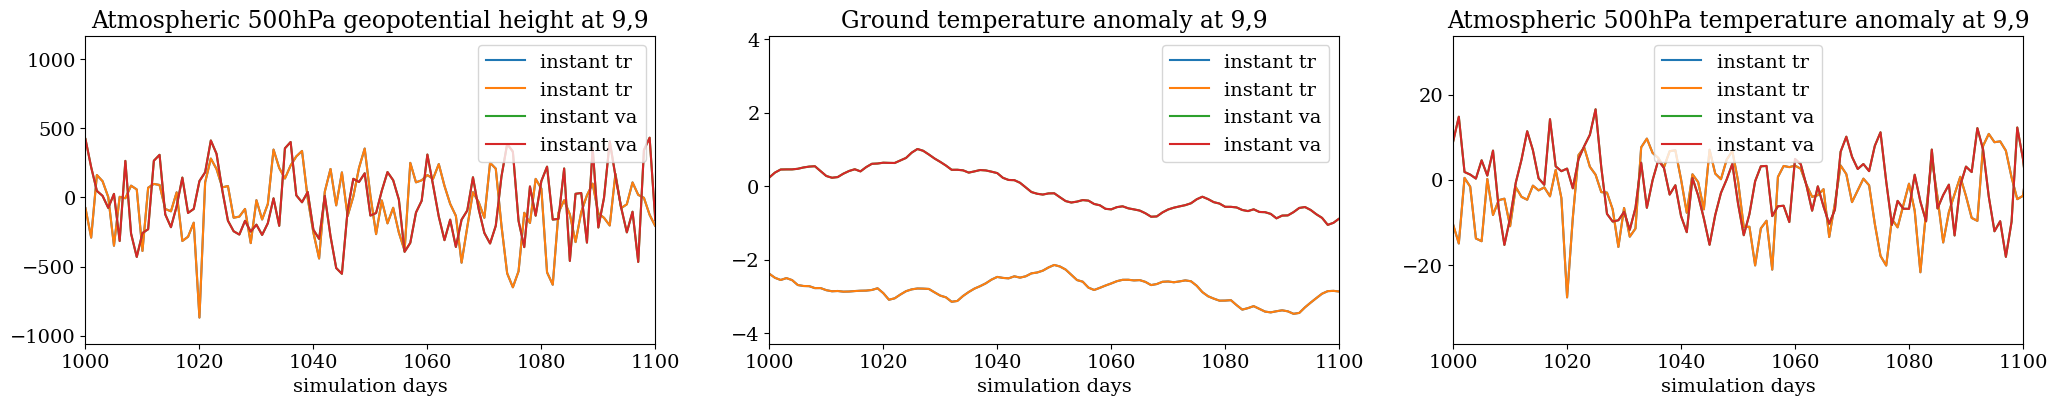

In [54]:
for sample_set in ['tr','va']:
    MiddleT[sample_set] = MiddleAtmosphericTemperatureDiagnostic(model_parameters, True)
    psi[sample_set] = MiddleAtmosphericStreamfunctionDiagnostic(model_parameters, geopotential=True)
    groundT[sample_set] = GroundTemperatureDiagnostic(model_parameters, True)

    for field in [psi[sample_set],groundT[sample_set],MiddleT[sample_set]]:
        field.set_data(reference_time[sample_set], reference_traj[sample_set])
        field.climatology = np.mean(field.diagnostic,0)
        field.std = np.std(field.diagnostic,0)
        field.anomaly = field.diagnostic - field.climatology
        
    x, y = 9, 9
for sample_set in ['tr','va']:
    A[sample_set], threshold[sample_set], list_extremes[sample_set], convseq = ComputeTimeAverage(MiddleT[sample_set].anomaly[:,x, y],T=1)
    print(f'{threshold[sample_set] = }, {np.sum(list_extremes[sample_set])/len(list_extremes[sample_set]) = }')
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(25,4),constrained_layout=False)
for sample_set in ['tr','va']:
    for j, field in enumerate([psi[sample_set],groundT[sample_set],MiddleT[sample_set]]):
        series_int, series_threshold, series_list_extremes, convseq = ComputeTimeAverage(field.anomaly[:,x, y],T=1)
        axs[j].plot(field._time*field._model_params.dimensional_time,field.anomaly[:,x,y],label=f'instant {sample_set}')
        axs[j].plot(field._time[:len(series_int)]*field._model_params.dimensional_time,series_int,label=f'instant {sample_set}')
        axs[j].set_xlabel('simulation days')
        axs[j].set_xlim([1000,1100])
        axs[j].set_title(field._plot_title+f' at {x},{y}')
        axs[j].legend(loc='best')

plt.show()

### Preparing inputs for NN (persistence)
We see that both training and validation sets have comparable 95 percentile thresholds. For now we will keep the percentiles the same, to be consistent with what was done for Plasim. However, intuitevely it seems more pertinent to fix threshold, since it is a physical thing, whereas percent should be a realization. We will first work with ground temperature (to predict ground temperature). We setup the model as follows, including subtracting the mean and dividing by standard deviation. 
* Here we introduce the lead time $\tau=1$ days which corresponds to predicting the next day. Otherwise ($\tau=0$ days) NN will be doing a trivial job of reconstructing the label based on given information. Actually it has to learn to associate the threshold with the observed value. We are going to keep the labels (in other words the dates we are predicting are the same) and shift X back in time 

In [69]:
# prepare normalized fields for the input in NN
for field in [groundT, psi, MiddleT]:
    field['tr'].std_regularized = field['tr'].std[field['tr'].std==0] = 1 # If there is no variance we shouldn't divide by zero
    field['tr'].normalized = (field['tr'].diagnostic[:len(list_extremes['tr']),...] - field['tr'].climatology)/field['tr'].std_regularized
    field['va'].normalized = (field['va'].diagnostic[:len(list_extremes['va']),...] - field['tr'].climatology)/field['tr'].std_regularized

tau = 1
X_tr = MiddleT['tr'].normalized[tau:,x,y]
y_tr = np.array(list_extremes['tr'][:-tau]) # we have to remove the tail so that X and y have the same dimensions
X_va = MiddleT['va'].normalized[tau:,x,y]
y_va = np.array(list_extremes['va'][:-tau]) # we have to remove the tail so that X and y have the same dimensions
print(f'{X_tr.shape = }, {X_va.shape = }, {y_tr.shape = }, {y_va.shape = }')

model_input_dim = X_tr.shape[1:] #(X.shape[1],X.shape[2])
#model = create_regularized_model(1e-5, 1)
model = create_Logistic(model_input_dim, regularizer='l2', regularizer_coef=1e-9)

print("model_input_dim = ",model_input_dim)

undersampling_factor=1

tf_sampling = tf.cast([0.5*np.log(undersampling_factor), -0.5*np.log(undersampling_factor)], tf.float32)
model.summary()
#METRICS=['accuracy',MCCMetric(2),ConfusionMatrixMetric(2)]   # the last two make the code run longer but give precise discrete prediction benchmarks
METRICS=['accuracy',MCCMetric(2),ConfusionMatrixMetric(2),CustomLoss(tf_sampling)]#tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=True)]#CustomLoss()]   # the last two make the code run longer but give precise discrete prediction benchmarks
#METRICS=['loss']
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 2e-4),
    #optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #If the predicted labels are not converted to a probability distribution by the last layer of the model (using sigmoid or softmax activation functions), we need to inform these three Cross-Entropy functions by setting their from_logits = True.
    #One advantage of using sparse categorical cross-entropy is it saves storage in memory as well as time in computation because it simply uses a single integer for a class, rather than a whole one-hot vector. This works despite the fact that the neural network has an one-hot vector output  
    metrics=METRICS   # the last two make the code run longer but give precise discrete prediction benchmarks
)
model_name='test'
   
# Create a callback that saves the model's weights

ckpt_callback = make_checkpoint_callback(model_name+"/cp-{epoch:04d}.ckpt", checkpoint_every=10)
model.save_weights(checkpoint_path.format(epoch=0))


X_tr.shape = (10000,), X_va.shape = (10000,), y_tr.shape = (10000,), y_va.shape = (10000,)
model_input_dim =  ()
Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None,)]                 0         
                                                                 
 flatten_11 (Flatten)        (None, 1)                 0         
                                                                 
 dense_11 (Dense)            (None, 2)                 4         
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [70]:
def probability_model(inputs,input_model): # This function is used to apply softmax to the output of the neural network
    x = input_model(inputs)
    outputs = layers.Softmax()(x)
    return keras.Model(inputs, outputs)
my_history=model.fit(X_tr, y_tr, batch_size=128, validation_data=(X_va,y_va), shuffle=True, callbacks=[ckpt_callback], epochs=300,verbose=2, class_weight=None)

model.save(model_name)
np.save(model_name+'_history.npy',my_history.history)

my_probability_model=(tf.keras.Sequential([ # softmax output to make a prediction
    model,
    tf.keras.layers.Softmax()
]))


Epoch 1/300


/home/scratch01/gmiloshe/conda/qgs/lib/python3.8/site-packages/keras/engine/training.py:2319: UserWarning: Metric MCCMetric implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()
/home/scratch01/gmiloshe/conda/qgs/lib/python3.8/site-packages/keras/engine/training.py:2319: UserWarning: Metric ConfusionMatrixMetric implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


79/79 - 2s - loss: 4.3144 - accuracy: 0.4509 - MCC: -2.0506e-01 - confusion_matrix: 2500.0000 - CustomLoss: 4.3144 - val_loss: 4.3549 - val_accuracy: 0.4417 - val_MCC: -2.0112e-01 - val_confusion_matrix: 2500.0000 - val_CustomLoss: 4.3549 - 2s/epoch - 20ms/step
Epoch 2/300
79/79 - 0s - loss: 4.1720 - accuracy: 0.4519 - MCC: -2.0460e-01 - confusion_matrix: 2500.0000 - CustomLoss: 4.1720 - val_loss: 4.2088 - val_accuracy: 0.4432 - val_MCC: -2.0124e-01 - val_confusion_matrix: 2500.0000 - val_CustomLoss: 4.2088 - 177ms/epoch - 2ms/step
Epoch 3/300
79/79 - 0s - loss: 4.0292 - accuracy: 0.4529 - MCC: -2.0414e-01 - confusion_matrix: 2500.0000 - CustomLoss: 4.0292 - val_loss: 4.0622 - val_accuracy: 0.4447 - val_MCC: -2.0218e-01 - val_confusion_matrix: 2500.0000 - val_CustomLoss: 4.0622 - 180ms/epoch - 2ms/step
Epoch 4/300
79/79 - 0s - loss: 3.8872 - accuracy: 0.4550 - MCC: -2.0400e-01 - confusion_matrix: 2500.0000 - CustomLoss: 3.8872 - val_loss: 3.9169 - val_accuracy: 0.4461 - val_MCC: -2.015

Tracking performance as a function of epoch

(0.0, 0.75)

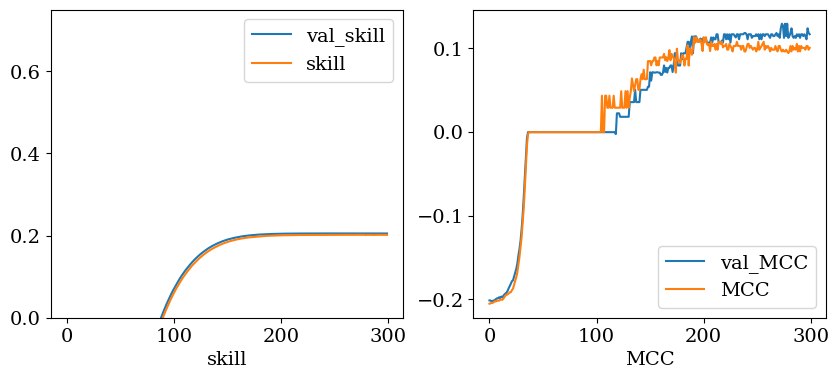

In [71]:
percent=5
maxskill = -(percent/100.)*np.log(percent/100.)-(1-percent/100.)*np.log(1-percent/100.)
my_history.history['val_skill'] =  (maxskill-my_history.history['val_loss'])/maxskill
my_history.history['skill'] =  (maxskill-my_history.history['loss'])/maxskill
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4),constrained_layout=False)

for j, metric in enumerate(['skill','MCC']):
    axs[j].plot(my_history.history[f'val_{metric}'],label=f'val_{metric}')
    axs[j].plot(my_history.history[metric],label=metric)
    axs[j].set_xlabel(metric)
    axs[j].legend(loc='best')

axs[0].set_ylim([0,.5])
axs[1].set_ylim([0,.5])

### Preparing inputs for NN (baroclinic)


In [72]:
# prepare normalized fields for the input in NN
for field in [groundT, psi, MiddleT]:
    field['tr'].std_regularized = field['tr'].std[field['tr'].std==0] = 1 # If there is no variance we shouldn't divide by zero
    field['tr'].normalized = (field['tr'].diagnostic[:len(list_extremes['tr']),...] - field['tr'].climatology)/field['tr'].std_regularized
    field['va'].normalized = (field['va'].diagnostic[:len(list_extremes['va']),...] - field['tr'].climatology)/field['tr'].std_regularized

tau = 1
X_tr = MiddleT['tr'].normalized[tau:]
y_tr = np.array(list_extremes['tr'][:-tau]) # we have to remove the tail so that X and y have the same dimensions
X_va = MiddleT['va'].normalized[tau:]
y_va = np.array(list_extremes['va'][:-tau]) # we have to remove the tail so that X and y have the same dimensions
print(f'{X_tr.shape = }, {X_va.shape = }, {y_tr.shape = }, {y_va.shape = }')

model_input_dim = X_tr.shape[1:] #(X.shape[1],X.shape[2])
#model = create_regularized_model(1e-5, 1)
model = create_Logistic(model_input_dim, regularizer='l2', regularizer_coef=1e-9)

print("model_input_dim = ",model_input_dim)

undersampling_factor=1

tf_sampling = tf.cast([0.5*np.log(undersampling_factor), -0.5*np.log(undersampling_factor)], tf.float32)
model.summary()
#METRICS=['accuracy',MCCMetric(2),ConfusionMatrixMetric(2)]   # the last two make the code run longer but give precise discrete prediction benchmarks
METRICS=['accuracy',MCCMetric(2),ConfusionMatrixMetric(2),CustomLoss(tf_sampling)]#tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=True)]#CustomLoss()]   # the last two make the code run longer but give precise discrete prediction benchmarks
#METRICS=['loss']
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 2e-4),
    #optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #If the predicted labels are not converted to a probability distribution by the last layer of the model (using sigmoid or softmax activation functions), we need to inform these three Cross-Entropy functions by setting their from_logits = True.
    #One advantage of using sparse categorical cross-entropy is it saves storage in memory as well as time in computation because it simply uses a single integer for a class, rather than a whole one-hot vector. This works despite the fact that the neural network has an one-hot vector output  
    metrics=METRICS   # the last two make the code run longer but give precise discrete prediction benchmarks
)
model_name='test'
   
# Create a callback that saves the model's weights

ckpt_callback = make_checkpoint_callback(model_name+"/cp-{epoch:04d}.ckpt", checkpoint_every=10)
model.save_weights(checkpoint_path.format(epoch=0))


X_tr.shape = (10000, 18, 19), X_va.shape = (10000, 18, 19), y_tr.shape = (10000,), y_va.shape = (10000,)
model_input_dim =  (18, 19)
Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 18, 19)]          0         
                                                                 
 flatten_12 (Flatten)        (None, 342)               0         
                                                                 
 dense_12 (Dense)            (None, 2)                 686       
                                                                 
Total params: 686
Trainable params: 686
Non-trainable params: 0
_________________________________________________________________


In [73]:
def probability_model(inputs,input_model): # This function is used to apply softmax to the output of the neural network
    x = input_model(inputs)
    outputs = layers.Softmax()(x)
    return keras.Model(inputs, outputs)
my_history=model.fit(X_tr, y_tr, batch_size=128, validation_data=(X_va,y_va), shuffle=True, callbacks=[ckpt_callback], epochs=300,verbose=2, class_weight=None)

model.save(model_name)
np.save(model_name+'_history.npy',my_history.history)

my_probability_model=(tf.keras.Sequential([ # softmax output to make a prediction
    model,
    tf.keras.layers.Softmax()
]))


Epoch 1/300


/home/scratch01/gmiloshe/conda/qgs/lib/python3.8/site-packages/keras/engine/training.py:2319: UserWarning: Metric MCCMetric implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()
/home/scratch01/gmiloshe/conda/qgs/lib/python3.8/site-packages/keras/engine/training.py:2319: UserWarning: Metric ConfusionMatrixMetric implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


79/79 - 2s - loss: 4.3363 - accuracy: 0.5004 - MCC: 0.0241 - confusion_matrix: 2500.0000 - CustomLoss: 4.3363 - val_loss: 2.6236 - val_accuracy: 0.5221 - val_MCC: 0.0548 - val_confusion_matrix: 2500.0000 - val_CustomLoss: 2.6236 - 2s/epoch - 21ms/step
Epoch 2/300
79/79 - 0s - loss: 1.6134 - accuracy: 0.5241 - MCC: 0.0961 - confusion_matrix: 2500.0000 - CustomLoss: 1.6134 - val_loss: 0.7989 - val_accuracy: 0.5561 - val_MCC: 0.1103 - val_confusion_matrix: 2500.0000 - val_CustomLoss: 0.7989 - 194ms/epoch - 2ms/step
Epoch 3/300
79/79 - 0s - loss: 0.6765 - accuracy: 0.6062 - MCC: 0.2076 - confusion_matrix: 2500.0000 - CustomLoss: 0.6765 - val_loss: 0.6396 - val_accuracy: 0.6654 - val_MCC: 0.2672 - val_confusion_matrix: 2500.0000 - val_CustomLoss: 0.6396 - 197ms/epoch - 2ms/step
Epoch 4/300
79/79 - 0s - loss: 0.6389 - accuracy: 0.6575 - MCC: 0.2525 - confusion_matrix: 2500.0000 - CustomLoss: 0.6389 - val_loss: 0.6232 - val_accuracy: 0.7023 - val_MCC: 0.2653 - val_confusion_matrix: 2500.0000 

Below we see that we reach acceptable metrics

(0.0, 0.5)

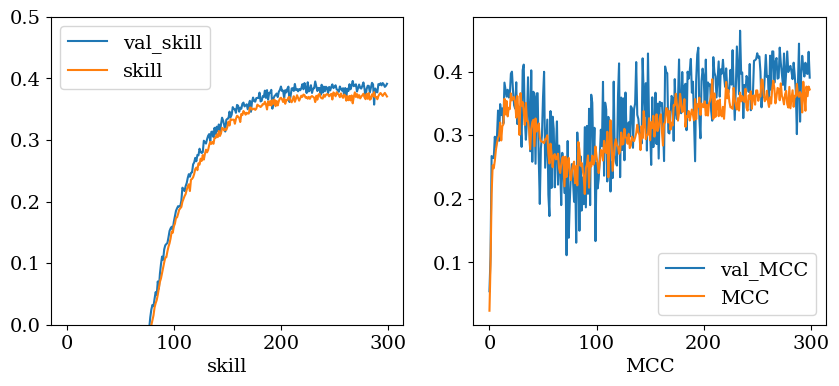

In [74]:
percent=5
maxskill = -(percent/100.)*np.log(percent/100.)-(1-percent/100.)*np.log(1-percent/100.)
my_history.history['val_skill'] =  (maxskill-my_history.history['val_loss'])/maxskill
my_history.history['skill'] =  (maxskill-my_history.history['loss'])/maxskill
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4),constrained_layout=False)

for j, metric in enumerate(['skill','MCC']):
    axs[j].plot(my_history.history[f'val_{metric}'],label=f'val_{metric}')
    axs[j].plot(my_history.history[metric],label=metric)
    axs[j].set_xlabel(metric)
    axs[j].legend(loc='best')

axs[0].set_ylim([0,.5])
axs[0].set_ylim([0,.5])

Baroclinic streamfunction is very relevant for the prediction

## Barotropic

In [76]:
tau = 1
X_tr = psi['tr'].normalized[tau:]
y_tr = np.array(list_extremes['tr'][:-tau]) # we have to remove the tail so that X and y have the same dimensions
X_va = psi['va'].normalized[tau:]
y_va = np.array(list_extremes['va'][:-tau]) # we have to remove the tail so that X and y have the same dimensions
print(f'{X_tr.shape = }, {X_va.shape = }, {y_tr.shape = }, {y_va.shape = }')

model_input_dim = X_tr.shape[1:] #(X.shape[1],X.shape[2])
#model = create_regularized_model(1e-5, 1)
model = create_Logistic(model_input_dim, regularizer='l2', regularizer_coef=1e-9)

print("model_input_dim = ",model_input_dim)

undersampling_factor=1

tf_sampling = tf.cast([0.5*np.log(undersampling_factor), -0.5*np.log(undersampling_factor)], tf.float32)
model.summary()
#METRICS=['accuracy',MCCMetric(2),ConfusionMatrixMetric(2)]   # the last two make the code run longer but give precise discrete prediction benchmarks
METRICS=['accuracy',MCCMetric(2),ConfusionMatrixMetric(2),CustomLoss(tf_sampling)]#tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=True)]#CustomLoss()]   # the last two make the code run longer but give precise discrete prediction benchmarks
#METRICS=['loss']
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 2e-4),
    #optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #If the predicted labels are not converted to a probability distribution by the last layer of the model (using sigmoid or softmax activation functions), we need to inform these three Cross-Entropy functions by setting their from_logits = True.
    #One advantage of using sparse categorical cross-entropy is it saves storage in memory as well as time in computation because it simply uses a single integer for a class, rather than a whole one-hot vector. This works despite the fact that the neural network has an one-hot vector output  
    metrics=METRICS   # the last two make the code run longer but give precise discrete prediction benchmarks
)
model_name='test'
   
# Create a callback that saves the model's weights

ckpt_callback = make_checkpoint_callback(model_name+"/cp-{epoch:04d}.ckpt", checkpoint_every=10)
model.save_weights(checkpoint_path.format(epoch=0))


X_tr.shape = (10000, 18, 18), X_va.shape = (10000, 18, 18), y_tr.shape = (10000,), y_va.shape = (10000,)
model_input_dim =  (18, 18)
Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 18, 18)]          0         
                                                                 
 flatten_14 (Flatten)        (None, 324)               0         
                                                                 
 dense_14 (Dense)            (None, 2)                 650       
                                                                 
Total params: 650
Trainable params: 650
Non-trainable params: 0
_________________________________________________________________


In [77]:
def probability_model(inputs,input_model): # This function is used to apply softmax to the output of the neural network
    x = input_model(inputs)
    outputs = layers.Softmax()(x)
    return keras.Model(inputs, outputs)
my_history=model.fit(X_tr, y_tr, batch_size=128, validation_data=(X_va,y_va), shuffle=True, callbacks=[ckpt_callback], epochs=300,verbose=2, class_weight=None)

model.save(model_name)
np.save(model_name+'_history.npy',my_history.history)

my_probability_model=(tf.keras.Sequential([ # softmax output to make a prediction
    model,
    tf.keras.layers.Softmax()
]))


Epoch 1/300


/home/scratch01/gmiloshe/conda/qgs/lib/python3.8/site-packages/keras/engine/training.py:2319: UserWarning: Metric MCCMetric implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()
/home/scratch01/gmiloshe/conda/qgs/lib/python3.8/site-packages/keras/engine/training.py:2319: UserWarning: Metric ConfusionMatrixMetric implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


79/79 - 2s - loss: 78.1936 - accuracy: 0.4992 - MCC: -1.0278e-02 - confusion_matrix: 2500.0000 - CustomLoss: 78.1936 - val_loss: 42.5440 - val_accuracy: 0.5137 - val_MCC: 0.0435 - val_confusion_matrix: 2500.0000 - val_CustomLoss: 42.5440 - 2s/epoch - 22ms/step
Epoch 2/300
79/79 - 0s - loss: 23.4769 - accuracy: 0.5073 - MCC: 0.0513 - confusion_matrix: 2500.0000 - CustomLoss: 23.4769 - val_loss: 7.2440 - val_accuracy: 0.5068 - val_MCC: 0.0485 - val_confusion_matrix: 2500.0000 - val_CustomLoss: 7.2440 - 212ms/epoch - 3ms/step
Epoch 3/300
79/79 - 0s - loss: 1.9690 - accuracy: 0.5217 - MCC: 0.0488 - confusion_matrix: 2500.0000 - CustomLoss: 1.9690 - val_loss: 0.9649 - val_accuracy: 0.5571 - val_MCC: 0.0893 - val_confusion_matrix: 2500.0000 - val_CustomLoss: 0.9649 - 214ms/epoch - 3ms/step
Epoch 4/300
79/79 - 0s - loss: 0.9148 - accuracy: 0.5442 - MCC: 0.0559 - confusion_matrix: 2500.0000 - CustomLoss: 0.9148 - val_loss: 1.0032 - val_accuracy: 0.5159 - val_MCC: 0.0569 - val_confusion_matrix:

It seems really hard to extract anything useful from the barotropic. It could be that we are in the regime of lack of data

(0.0, 0.5)

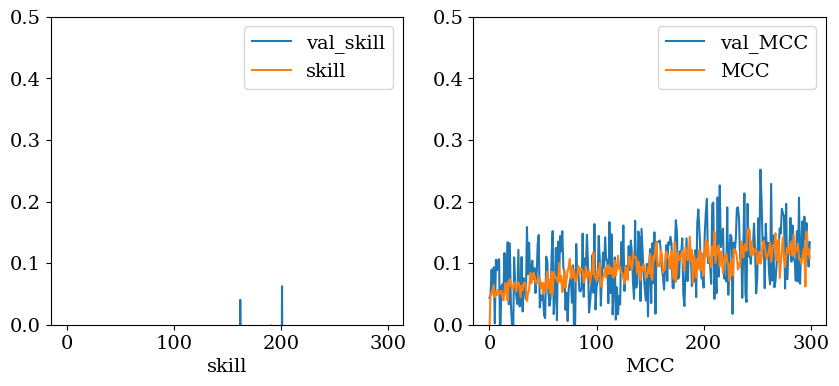

In [78]:
percent=5
maxskill = -(percent/100.)*np.log(percent/100.)-(1-percent/100.)*np.log(1-percent/100.)
my_history.history['val_skill'] =  (maxskill-my_history.history['val_loss'])/maxskill
my_history.history['skill'] =  (maxskill-my_history.history['loss'])/maxskill
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4),constrained_layout=False)

for j, metric in enumerate(['skill','MCC']):
    axs[j].plot(my_history.history[f'val_{metric}'],label=f'val_{metric}')
    axs[j].plot(my_history.history[metric],label=metric)
    axs[j].set_xlabel(metric)
    axs[j].legend(loc='best')

axs[0].set_ylim([0,.5])
axs[1].set_ylim([0,.5])

Trying stronger regularization

X_tr.shape = (10000, 18, 18), X_va.shape = (10000, 18, 18), y_tr.shape = (10000,), y_va.shape = (10000,)
model_input_dim =  (18, 18)
Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 18, 18)]          0         
                                                                 
 flatten_18 (Flatten)        (None, 324)               0         
                                                                 
 dense_18 (Dense)            (None, 2)                 650       
                                                                 
Total params: 650
Trainable params: 650
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300


/home/scratch01/gmiloshe/conda/qgs/lib/python3.8/site-packages/keras/engine/training.py:2319: UserWarning: Metric MCCMetric implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()
/home/scratch01/gmiloshe/conda/qgs/lib/python3.8/site-packages/keras/engine/training.py:2319: UserWarning: Metric ConfusionMatrixMetric implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


79/79 - 2s - loss: 119.4899 - accuracy: 0.5004 - MCC: 0.0291 - confusion_matrix: 2500.0000 - CustomLoss: 115.6009 - val_loss: 75.4501 - val_accuracy: 0.5241 - val_MCC: 0.0755 - val_confusion_matrix: 2500.0000 - val_CustomLoss: 71.6227 - 2s/epoch - 21ms/step
Epoch 2/300
79/79 - 0s - loss: 50.2200 - accuracy: 0.5192 - MCC: 0.0765 - confusion_matrix: 2500.0000 - CustomLoss: 46.4300 - val_loss: 27.5863 - val_accuracy: 0.5099 - val_MCC: 0.0698 - val_confusion_matrix: 2500.0000 - val_CustomLoss: 23.8283 - 192ms/epoch - 2ms/step
Epoch 3/300
79/79 - 0s - loss: 12.7595 - accuracy: 0.5153 - MCC: 0.0632 - confusion_matrix: 2500.0000 - CustomLoss: 9.0147 - val_loss: 4.7268 - val_accuracy: 0.5384 - val_MCC: 0.0384 - val_confusion_matrix: 2500.0000 - val_CustomLoss: 0.9903 - 185ms/epoch - 2ms/step
Epoch 4/300
79/79 - 0s - loss: 4.6842 - accuracy: 0.5327 - MCC: 0.0456 - confusion_matrix: 2500.0000 - CustomLoss: 0.9562 - val_loss: 4.7196 - val_accuracy: 0.5583 - val_MCC: 0.1047 - val_confusion_matrix:

(0.0, 0.5)

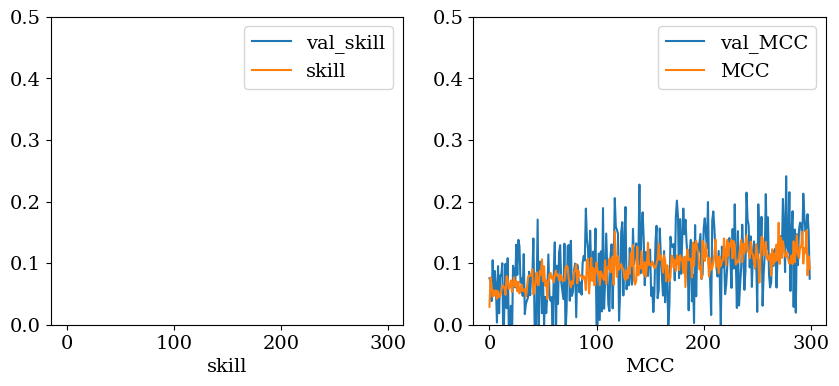

In [83]:
tau = 1
X_tr = psi['tr'].normalized[tau:]
y_tr = np.array(list_extremes['tr'][:-tau]) # we have to remove the tail so that X and y have the same dimensions
X_va = psi['va'].normalized[tau:]
y_va = np.array(list_extremes['va'][:-tau]) # we have to remove the tail so that X and y have the same dimensions
print(f'{X_tr.shape = }, {X_va.shape = }, {y_tr.shape = }, {y_va.shape = }')

model_input_dim = X_tr.shape[1:] #(X.shape[1],X.shape[2])
#model = create_regularized_model(1e-5, 1)
model = create_Logistic(model_input_dim, regularizer='l2', regularizer_coef=1e0)

print("model_input_dim = ",model_input_dim)

undersampling_factor=1

tf_sampling = tf.cast([0.5*np.log(undersampling_factor), -0.5*np.log(undersampling_factor)], tf.float32)
model.summary()
#METRICS=['accuracy',MCCMetric(2),ConfusionMatrixMetric(2)]   # the last two make the code run longer but give precise discrete prediction benchmarks
METRICS=['accuracy',MCCMetric(2),ConfusionMatrixMetric(2),CustomLoss(tf_sampling)]#tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=True)]#CustomLoss()]   # the last two make the code run longer but give precise discrete prediction benchmarks
#METRICS=['loss']
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 2e-4),
    #optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #If the predicted labels are not converted to a probability distribution by the last layer of the model (using sigmoid or softmax activation functions), we need to inform these three Cross-Entropy functions by setting their from_logits = True.
    #One advantage of using sparse categorical cross-entropy is it saves storage in memory as well as time in computation because it simply uses a single integer for a class, rather than a whole one-hot vector. This works despite the fact that the neural network has an one-hot vector output  
    metrics=METRICS   # the last two make the code run longer but give precise discrete prediction benchmarks
)
model_name='test'
   
# Create a callback that saves the model's weights

ckpt_callback = make_checkpoint_callback(model_name+"/cp-{epoch:04d}.ckpt", checkpoint_every=10)
model.save_weights(checkpoint_path.format(epoch=0))


def probability_model(inputs,input_model): # This function is used to apply softmax to the output of the neural network
    x = input_model(inputs)
    outputs = layers.Softmax()(x)
    return keras.Model(inputs, outputs)
my_history=model.fit(X_tr, y_tr, batch_size=128, validation_data=(X_va,y_va), shuffle=True, callbacks=[ckpt_callback], epochs=300,verbose=2, class_weight=None)

model.save(model_name)
np.save(model_name+'_history.npy',my_history.history)

my_probability_model=(tf.keras.Sequential([ # softmax output to make a prediction
    model,
    tf.keras.layers.Softmax()
]))
percent=5
maxskill = -(percent/100.)*np.log(percent/100.)-(1-percent/100.)*np.log(1-percent/100.)
my_history.history['val_skill'] =  (maxskill-my_history.history['val_loss'])/maxskill
my_history.history['skill'] =  (maxskill-my_history.history['loss'])/maxskill
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4),constrained_layout=False)

for j, metric in enumerate(['skill','MCC']):
    axs[j].plot(my_history.history[f'val_{metric}'],label=f'val_{metric}')
    axs[j].plot(my_history.history[metric],label=metric)
    axs[j].set_xlabel(metric)
    axs[j].legend(loc='best')

axs[0].set_ylim([0,.5])
axs[1].set_ylim([0,.5])

Fortunately we have more data at our disposal so we can quickly check if more data helps predict

## More data

In [84]:
## Systems definition
#General parameters. I am selecting standard parameters for the runs below, not sure if this is what Robin is using
# Time parameters


#The other parameters can come from model1.pickle that Robin prepared:
import pickle
# loading the model
with open('model1.pickle', "rb") as file:
    model = pickle.load(file)

f = model['f']
Df = model['Df']
model_parameters = model['parameters']
# Printing the model's parameters
model_parameters.print_params()

dt =  0.01/model_parameters.dimensional_time # we made dt a bit smaller so that we get daily output
# Saving the model state n steps
write_steps = 100 # It seems to me that time = 18 is interpreted as 1 day by some routines. This way we will force the output to be daily (write every `write_steps` iterations)

number_of_trajectories = 1
number_of_perturbed_trajectories = 10
#Why did Robin choose n = 0.353? Otherwise the setup is similar to ground_heat.ipynb but with more spectral components. It is not clear to me if we need many spectral components. The typical setup with fewer components is usually enough to provide some realism. 

#Parameters that are different:
#* Atmospheric Temperature parameters
#    * 'C[1]' : 122 [W][m^-2] instead of 99 [W][m^-2]: (spectral component 1 of the short-wave radiation of the atmosphere), other C's are zero
#    * 'hlambda': 20  [W][m^-2][K^-1] instead of 10 [W][m^-2][K^-1] (sensible+turbulent heat exchange between ocean and atmosphere),
#* Ground Parameters:
#    * 'hk[2]': 0.4 instead of 0.2    (spectral components 2 of the orography), other h'k are zero
#* Ground Temperature Parameters:
#    * 'gamma': 200000000  [J][m^-2][K^-1] instead of 16000000  (specific heat capacity of the ground),
#    * 'C[1]': 280.0  [W][m^-2]  (spectral component 1 of the short-wave radiation of the ground), other C parameters are zero
#Below we can also investigate what fields that are actually used 
# model_parameters.latex_var_string

# Now we create the test and train trajectories.
ndays=100000 # how many days to generate

f, Df, ic, time, reference_traj, reference_time, MiddleT, psi, groundT, timedimensional, A, threshold, list_extremes = {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}
for sample_set in ['tr','va']:
    trajfilename = f'data/traj_{sample_set}_{ndays}.nc' # to create new trajectories rename the file or remove it form the directory
    if not os.path.exists(trajfilename): 
        f[sample_set], Df[sample_set] = create_tendencies(model_parameters)
        print('tendencies created')
        ## Time integration
        #Defining an integrator
        integrator = RungeKuttaIntegrator()
        integrator.set_func(f[sample_set])
        #Start on a random initial condition and integrate over a transient time to obtain an initial condition on the attractors. I kept the standard time that is typically used in other runs, so not sure if it perfectly adapted...
        print('integrator set up')
        ic[sample_set] = np.random.rand(model_parameters.ndim)*0.1
        integrator.integrate(0., 30000/model_parameters.dimensional_time, dt, ic=ic[sample_set], write_steps=0) # actually 200000 should be enought according to rare_statistics.ipynb
        time[sample_set], ic[sample_set] = integrator.get_trajectories()
        print(f"done generating initial coordinates with {time[sample_set] = } and {time[sample_set]*model_parameters.dimensional_time = }")

        #Now integrate to obtain a trajectory on the attractor
        integrator.integrate(0., 10000/model_parameters.dimensional_time, dt, ic=ic[sample_set], write_steps=write_steps)
        reference_time[sample_set], reference_traj[sample_set] = integrator.get_trajectories()
        ds = xr.Dataset(data_vars=dict(traj=(["comp", "time"], reference_traj[sample_set])), coords=dict(time=reference_time[sample_set]), attrs=dict(description="Components of the trajectory."))
        print(f'saving {trajfilename}')
        ds.to_netcdf(trajfilename) 
    else:
        print(f'loading {trajfilename}')
        ds= xr.open_dataset(trajfilename)
        reference_time[sample_set], reference_traj[sample_set] = ds.time.values, ds.traj.values
        
        


    MiddleT[sample_set] = MiddleAtmosphericTemperatureDiagnostic(model_parameters, True)
    psi[sample_set] = MiddleAtmosphericStreamfunctionDiagnostic(model_parameters, geopotential=True)
    groundT[sample_set] = GroundTemperatureDiagnostic(model_parameters, True)

    for field in [psi[sample_set],groundT[sample_set],MiddleT[sample_set]]:
        field.set_data(reference_time[sample_set], reference_traj[sample_set])
        field.climatology = np.mean(field.diagnostic,0)
        field.std = np.std(field.diagnostic,0)
        field.anomaly = field.diagnostic - field.climatology

/home/scratch01/gmiloshe/tests/qgs/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
  warnings.warn("Parameter configured to perform dimensional conversion " +


Qgs v0.2.5 parameters summary

General Parameters:
'time_unit': days,
'rr': 287.058  [J][kg^-1][K^-1]  (gas constant of dry air),
'sb': 5.67e-08  [J][m^-2][s^-1][K^-4]  (Stefan-Boltzmann constant),

Scale Parameters:
'scale': 5000000.0  [m]  (characteristic space scale (L*pi)),
'f0': 0.0001032  [s^-1]  (Coriolis parameter at the middle of the domain),
'n': 0.353    (aspect ratio (n = 2 L_y / L_x)),
'rra': 6370000.0  [m]  (earth radius),
'phi0_npi': 0.25    (latitude expressed in fraction of pi),
'deltap': 50000.0  [Pa]  (pressure difference between the two atmospheric layers),

Atmospheric Parameters:
'kd': 0.1  [nondim]  (atmosphere bottom friction coefficient),
'kdp': 0.01  [nondim]  (atmosphere internal friction coefficient),
'sigma': 0.2  [nondim]  (static stability of the atmosphere),

Atmospheric Temperature Parameters:
'gamma': 10000000.0  [J][m^-2][K^-1]  (specific heat capacity of the atmosphere),
'C[1]': 112.0  [W][m^-2]  (spectral component 1 of the short-wave radiation of t

Daily extremes must be computed again

In [88]:
for sample_set in ['tr','va']:
    MiddleT[sample_set] = MiddleAtmosphericTemperatureDiagnostic(model_parameters, True)
    psi[sample_set] = MiddleAtmosphericStreamfunctionDiagnostic(model_parameters, geopotential=True)
    groundT[sample_set] = GroundTemperatureDiagnostic(model_parameters, True)

    for field in [psi[sample_set],groundT[sample_set],MiddleT[sample_set]]:
        field.set_data(reference_time[sample_set], reference_traj[sample_set])
        field.climatology = np.mean(field.diagnostic,0)
        field.std = np.std(field.diagnostic,0)
        field.anomaly = field.diagnostic - field.climatology
        
    x, y = 9, 9
for sample_set in ['tr','va']:
    A[sample_set], threshold[sample_set], list_extremes[sample_set], convseq = ComputeTimeAverage(MiddleT[sample_set].anomaly[:,x, y],T=1)
    print(f'{threshold[sample_set] = }, {np.sum(list_extremes[sample_set])/len(list_extremes[sample_set]) = }')

# prepare normalized fields for the input in NN
for field in [groundT, psi, MiddleT]:
    field['tr'].std_regularized = field['tr'].std[field['tr'].std==0] = 1 # If there is no variance we shouldn't divide by zero
    field['tr'].normalized = (field['tr'].diagnostic[:len(list_extremes['tr']),...] - field['tr'].climatology)/field['tr'].std_regularized
    field['va'].normalized = (field['va'].diagnostic[:len(list_extremes['va']),...] - field['tr'].climatology)/field['tr'].std_regularized

T = 1
len(list_extremes) = 100001
threshold[sample_set] = 15.047088419906963, np.sum(list_extremes[sample_set])/len(list_extremes[sample_set]) = 0.04999950000499995
T = 1
len(list_extremes) = 100001
threshold[sample_set] = 14.991718916517343, np.sum(list_extremes[sample_set])/len(list_extremes[sample_set]) = 0.04999950000499995


X_tr.shape = (100000, 18, 18), X_va.shape = (100000, 18, 18), y_tr.shape = (100000,), y_va.shape = (100000,)
model_input_dim =  (18, 18)
Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 18, 18)]          0         
                                                                 
 flatten_19 (Flatten)        (None, 324)               0         
                                                                 
 dense_19 (Dense)            (None, 2)                 650       
                                                                 
Total params: 650
Trainable params: 650
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300


/home/scratch01/gmiloshe/conda/qgs/lib/python3.8/site-packages/keras/engine/training.py:2319: UserWarning: Metric MCCMetric implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()
/home/scratch01/gmiloshe/conda/qgs/lib/python3.8/site-packages/keras/engine/training.py:2319: UserWarning: Metric ConfusionMatrixMetric implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


782/782 - 3s - loss: 15.4079 - accuracy: 0.5459 - MCC: 0.0601 - confusion_matrix: 25000.0000 - CustomLoss: 15.4079 - val_loss: 0.8497 - val_accuracy: 0.5523 - val_MCC: 0.0264 - val_confusion_matrix: 25000.0000 - val_CustomLoss: 0.8497 - 3s/epoch - 4ms/step
Epoch 2/300
782/782 - 2s - loss: 0.7090 - accuracy: 0.6271 - MCC: 0.0600 - confusion_matrix: 25000.0000 - CustomLoss: 0.7090 - val_loss: 0.6319 - val_accuracy: 0.6603 - val_MCC: 0.1230 - val_confusion_matrix: 25000.0000 - val_CustomLoss: 0.6319 - 2s/epoch - 2ms/step
Epoch 3/300
782/782 - 2s - loss: 0.6110 - accuracy: 0.6921 - MCC: 0.0681 - confusion_matrix: 25000.0000 - CustomLoss: 0.6110 - val_loss: 0.6991 - val_accuracy: 0.6816 - val_MCC: 0.1169 - val_confusion_matrix: 25000.0000 - val_CustomLoss: 0.6991 - 2s/epoch - 2ms/step
Epoch 4/300
782/782 - 2s - loss: 0.5190 - accuracy: 0.7540 - MCC: 0.0764 - confusion_matrix: 25000.0000 - CustomLoss: 0.5190 - val_loss: 0.5277 - val_accuracy: 0.7416 - val_MCC: -3.2939e-03 - val_confusion_mat

(0.0, 0.5)

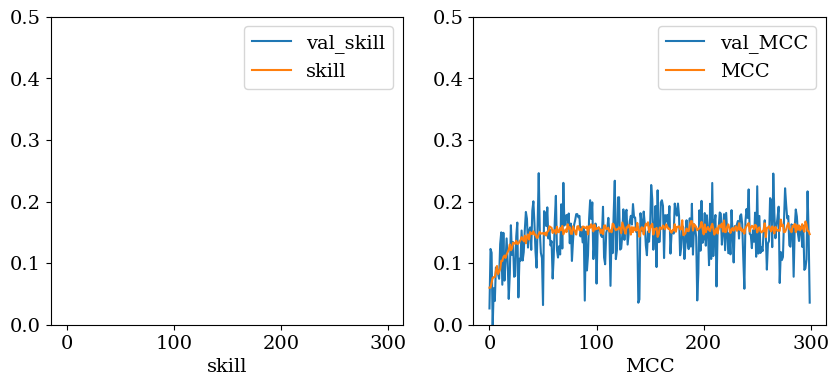

In [89]:
tau = 1
X_tr = psi['tr'].normalized[tau:]
y_tr = np.array(list_extremes['tr'][:-tau]) # we have to remove the tail so that X and y have the same dimensions
X_va = psi['va'].normalized[tau:]
y_va = np.array(list_extremes['va'][:-tau]) # we have to remove the tail so that X and y have the same dimensions
print(f'{X_tr.shape = }, {X_va.shape = }, {y_tr.shape = }, {y_va.shape = }')

model_input_dim = X_tr.shape[1:] #(X.shape[1],X.shape[2])
#model = create_regularized_model(1e-5, 1)
model = create_Logistic(model_input_dim, regularizer='l2', regularizer_coef=1e-9)

print("model_input_dim = ",model_input_dim)

undersampling_factor=1

tf_sampling = tf.cast([0.5*np.log(undersampling_factor), -0.5*np.log(undersampling_factor)], tf.float32)
model.summary()
#METRICS=['accuracy',MCCMetric(2),ConfusionMatrixMetric(2)]   # the last two make the code run longer but give precise discrete prediction benchmarks
METRICS=['accuracy',MCCMetric(2),ConfusionMatrixMetric(2),CustomLoss(tf_sampling)]#tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=True)]#CustomLoss()]   # the last two make the code run longer but give precise discrete prediction benchmarks
#METRICS=['loss']
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 2e-4),
    #optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #If the predicted labels are not converted to a probability distribution by the last layer of the model (using sigmoid or softmax activation functions), we need to inform these three Cross-Entropy functions by setting their from_logits = True.
    #One advantage of using sparse categorical cross-entropy is it saves storage in memory as well as time in computation because it simply uses a single integer for a class, rather than a whole one-hot vector. This works despite the fact that the neural network has an one-hot vector output  
    metrics=METRICS   # the last two make the code run longer but give precise discrete prediction benchmarks
)
model_name='test'
   
# Create a callback that saves the model's weights

ckpt_callback = make_checkpoint_callback(model_name+"/cp-{epoch:04d}.ckpt", checkpoint_every=10)
model.save_weights(checkpoint_path.format(epoch=0))


def probability_model(inputs,input_model): # This function is used to apply softmax to the output of the neural network
    x = input_model(inputs)
    outputs = layers.Softmax()(x)
    return keras.Model(inputs, outputs)
my_history=model.fit(X_tr, y_tr, batch_size=128, validation_data=(X_va,y_va), shuffle=True, callbacks=[ckpt_callback], epochs=300,verbose=2, class_weight=None)

model.save(model_name)
np.save(model_name+'_history.npy',my_history.history)

my_probability_model=(tf.keras.Sequential([ # softmax output to make a prediction
    model,
    tf.keras.layers.Softmax()
]))
percent=5
maxskill = -(percent/100.)*np.log(percent/100.)-(1-percent/100.)*np.log(1-percent/100.)
my_history.history['val_skill'] =  (maxskill-my_history.history['val_loss'])/maxskill
my_history.history['skill'] =  (maxskill-my_history.history['loss'])/maxskill
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4),constrained_layout=False)

for j, metric in enumerate(['skill','MCC']):
    axs[j].plot(my_history.history[f'val_{metric}'],label=f'val_{metric}')
    axs[j].plot(my_history.history[metric],label=metric)
    axs[j].set_xlabel(metric)
    axs[j].legend(loc='best')

axs[0].set_ylim([0,.5])
axs[1].set_ylim([0,.5])

Surprisingly we do not get any logarithmic skill and we get marginal MCC. This is surprising because we have seen that composite maps do in fact reveal geopotential teleconnection. Another objective is to compute 5 day probabilities

In [90]:
for sample_set in ['tr','va']:
    MiddleT[sample_set] = MiddleAtmosphericTemperatureDiagnostic(model_parameters, True)
    psi[sample_set] = MiddleAtmosphericStreamfunctionDiagnostic(model_parameters, geopotential=True)
    groundT[sample_set] = GroundTemperatureDiagnostic(model_parameters, True)

    for field in [psi[sample_set],groundT[sample_set],MiddleT[sample_set]]:
        field.set_data(reference_time[sample_set], reference_traj[sample_set])
        field.climatology = np.mean(field.diagnostic,0)
        field.std = np.std(field.diagnostic,0)
        field.anomaly = field.diagnostic - field.climatology
        
    x, y = 9, 9
for sample_set in ['tr','va']:
    A[sample_set], threshold[sample_set], list_extremes[sample_set], convseq = ComputeTimeAverage(MiddleT[sample_set].anomaly[:,x, y],T=5)
    print(f'{threshold[sample_set] = }, {np.sum(list_extremes[sample_set])/len(list_extremes[sample_set]) = }')

# prepare normalized fields for the input in NN
for field in [groundT, psi, MiddleT]:
    field['tr'].std_regularized = field['tr'].std[field['tr'].std==0] = 1 # If there is no variance we shouldn't divide by zero
    field['tr'].normalized = (field['tr'].diagnostic[:len(list_extremes['tr']),...] - field['tr'].climatology)/field['tr'].std_regularized
    field['va'].normalized = (field['va'].diagnostic[:len(list_extremes['va']),...] - field['tr'].climatology)/field['tr'].std_regularized

T = 5
len(list_extremes) = 99997
threshold[sample_set] = 9.905007330564043, np.sum(list_extremes[sample_set])/len(list_extremes[sample_set]) = 0.04999149974499235
T = 5
len(list_extremes) = 99997
threshold[sample_set] = 9.866254687594122, np.sum(list_extremes[sample_set])/len(list_extremes[sample_set]) = 0.04999149974499235


X_tr.shape = (99996, 18, 18), X_va.shape = (99996, 18, 18), y_tr.shape = (99996,), y_va.shape = (99996,)
model_input_dim =  (18, 18)
Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 18, 18)]          0         
                                                                 
 flatten_20 (Flatten)        (None, 324)               0         
                                                                 
 dense_20 (Dense)            (None, 2)                 650       
                                                                 
Total params: 650
Trainable params: 650
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300


/home/scratch01/gmiloshe/conda/qgs/lib/python3.8/site-packages/keras/engine/training.py:2319: UserWarning: Metric MCCMetric implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()
/home/scratch01/gmiloshe/conda/qgs/lib/python3.8/site-packages/keras/engine/training.py:2319: UserWarning: Metric ConfusionMatrixMetric implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


782/782 - 3s - loss: 18.4379 - accuracy: 0.5506 - MCC: 0.0707 - confusion_matrix: 24999.0000 - CustomLoss: 18.4379 - val_loss: 0.8359 - val_accuracy: 0.5630 - val_MCC: -2.0097e-02 - val_confusion_matrix: 24999.0000 - val_CustomLoss: 0.8359 - 3s/epoch - 4ms/step
Epoch 2/300
782/782 - 2s - loss: 0.7361 - accuracy: 0.6220 - MCC: 0.0807 - confusion_matrix: 24999.0000 - CustomLoss: 0.7361 - val_loss: 0.6152 - val_accuracy: 0.6743 - val_MCC: 0.0628 - val_confusion_matrix: 24999.0000 - val_CustomLoss: 0.6152 - 2s/epoch - 2ms/step
Epoch 3/300
782/782 - 2s - loss: 0.6076 - accuracy: 0.6935 - MCC: 0.0867 - confusion_matrix: 24999.0000 - CustomLoss: 0.6076 - val_loss: 0.5873 - val_accuracy: 0.6973 - val_MCC: 0.0090 - val_confusion_matrix: 24999.0000 - val_CustomLoss: 0.5873 - 2s/epoch - 2ms/step
Epoch 4/300
782/782 - 2s - loss: 0.5101 - accuracy: 0.7580 - MCC: 0.1043 - confusion_matrix: 24999.0000 - CustomLoss: 0.5101 - val_loss: 0.4711 - val_accuracy: 0.7813 - val_MCC: 0.1197 - val_confusion_mat

(0.0, 0.5)

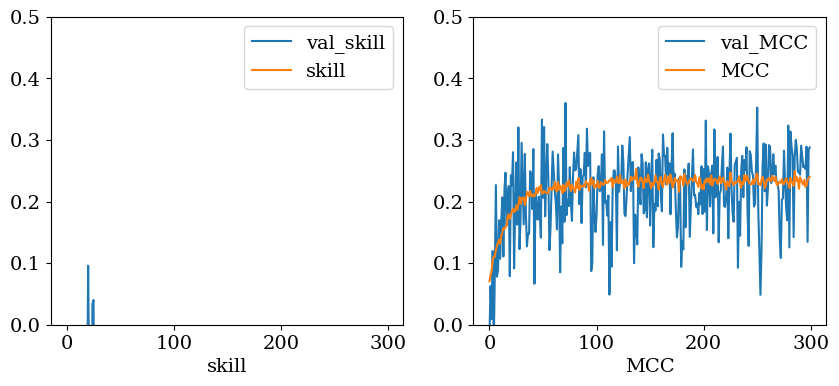

In [91]:
tau = 1
X_tr = psi['tr'].normalized[tau:]
y_tr = np.array(list_extremes['tr'][:-tau]) # we have to remove the tail so that X and y have the same dimensions
X_va = psi['va'].normalized[tau:]
y_va = np.array(list_extremes['va'][:-tau]) # we have to remove the tail so that X and y have the same dimensions
print(f'{X_tr.shape = }, {X_va.shape = }, {y_tr.shape = }, {y_va.shape = }')

model_input_dim = X_tr.shape[1:] #(X.shape[1],X.shape[2])
#model = create_regularized_model(1e-5, 1)
model = create_Logistic(model_input_dim, regularizer='l2', regularizer_coef=1e-9)

print("model_input_dim = ",model_input_dim)

undersampling_factor=1

tf_sampling = tf.cast([0.5*np.log(undersampling_factor), -0.5*np.log(undersampling_factor)], tf.float32)
model.summary()
#METRICS=['accuracy',MCCMetric(2),ConfusionMatrixMetric(2)]   # the last two make the code run longer but give precise discrete prediction benchmarks
METRICS=['accuracy',MCCMetric(2),ConfusionMatrixMetric(2),CustomLoss(tf_sampling)]#tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=True)]#CustomLoss()]   # the last two make the code run longer but give precise discrete prediction benchmarks
#METRICS=['loss']
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 2e-4),
    #optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #If the predicted labels are not converted to a probability distribution by the last layer of the model (using sigmoid or softmax activation functions), we need to inform these three Cross-Entropy functions by setting their from_logits = True.
    #One advantage of using sparse categorical cross-entropy is it saves storage in memory as well as time in computation because it simply uses a single integer for a class, rather than a whole one-hot vector. This works despite the fact that the neural network has an one-hot vector output  
    metrics=METRICS   # the last two make the code run longer but give precise discrete prediction benchmarks
)
model_name='test'
   
# Create a callback that saves the model's weights

ckpt_callback = make_checkpoint_callback(model_name+"/cp-{epoch:04d}.ckpt", checkpoint_every=10)
model.save_weights(checkpoint_path.format(epoch=0))


def probability_model(inputs,input_model): # This function is used to apply softmax to the output of the neural network
    x = input_model(inputs)
    outputs = layers.Softmax()(x)
    return keras.Model(inputs, outputs)
my_history=model.fit(X_tr, y_tr, batch_size=128, validation_data=(X_va,y_va), shuffle=True, callbacks=[ckpt_callback], epochs=300,verbose=2, class_weight=None)

model.save(model_name)
np.save(model_name+'_history.npy',my_history.history)

my_probability_model=(tf.keras.Sequential([ # softmax output to make a prediction
    model,
    tf.keras.layers.Softmax()
]))
percent=5
maxskill = -(percent/100.)*np.log(percent/100.)-(1-percent/100.)*np.log(1-percent/100.)
my_history.history['val_skill'] =  (maxskill-my_history.history['val_loss'])/maxskill
my_history.history['skill'] =  (maxskill-my_history.history['loss'])/maxskill
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4),constrained_layout=False)

for j, metric in enumerate(['skill','MCC']):
    axs[j].plot(my_history.history[f'val_{metric}'],label=f'val_{metric}')
    axs[j].plot(my_history.history[metric],label=metric)
    axs[j].set_xlabel(metric)
    axs[j].legend(loc='best')

axs[0].set_ylim([0,.5])
axs[1].set_ylim([0,.5])

We also compute the predictive skill of middle-atmosphere temperature for 5 day events and more data

X_tr.shape = (99996, 18, 19), X_va.shape = (99996, 18, 19), y_tr.shape = (99996,), y_va.shape = (99996,)
model_input_dim =  (18, 19)
Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 18, 19)]          0         
                                                                 
 flatten_21 (Flatten)        (None, 342)               0         
                                                                 
 dense_21 (Dense)            (None, 2)                 686       
                                                                 
Total params: 686
Trainable params: 686
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300


/home/scratch01/gmiloshe/conda/qgs/lib/python3.8/site-packages/keras/engine/training.py:2319: UserWarning: Metric MCCMetric implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()
/home/scratch01/gmiloshe/conda/qgs/lib/python3.8/site-packages/keras/engine/training.py:2319: UserWarning: Metric ConfusionMatrixMetric implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


782/782 - 3s - loss: 1.0435 - accuracy: 0.6732 - MCC: 0.2294 - confusion_matrix: 24999.0000 - CustomLoss: 1.0435 - val_loss: 0.5614 - val_accuracy: 0.8173 - val_MCC: 0.2910 - val_confusion_matrix: 24999.0000 - val_CustomLoss: 0.5614 - 3s/epoch - 4ms/step
Epoch 2/300
782/782 - 2s - loss: 0.5099 - accuracy: 0.8525 - MCC: 0.3382 - confusion_matrix: 24999.0000 - CustomLoss: 0.5099 - val_loss: 0.4625 - val_accuracy: 0.9007 - val_MCC: 0.3725 - val_confusion_matrix: 24999.0000 - val_CustomLoss: 0.4625 - 2s/epoch - 2ms/step
Epoch 3/300
782/782 - 2s - loss: 0.4238 - accuracy: 0.9232 - MCC: 0.3680 - confusion_matrix: 24999.0000 - CustomLoss: 0.4238 - val_loss: 0.3859 - val_accuracy: 0.9442 - val_MCC: 0.4093 - val_confusion_matrix: 24999.0020 - val_CustomLoss: 0.3859 - 2s/epoch - 2ms/step
Epoch 4/300
782/782 - 2s - loss: 0.3573 - accuracy: 0.9452 - MCC: 0.3509 - confusion_matrix: 24999.0000 - CustomLoss: 0.3573 - val_loss: 0.3303 - val_accuracy: 0.9515 - val_MCC: 0.2136 - val_confusion_matrix: 24

(0.0, 0.5)

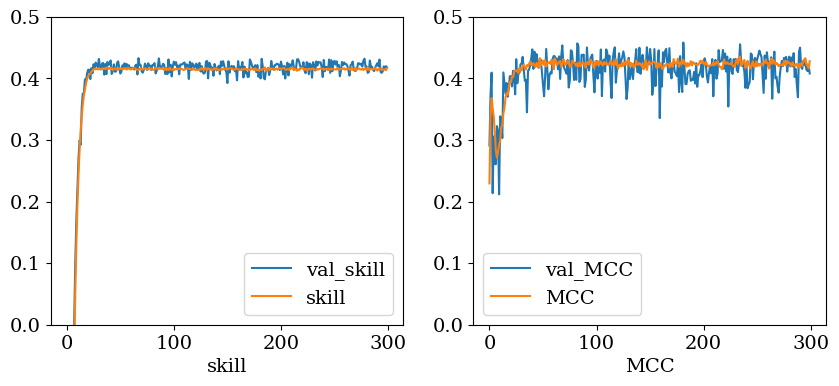

In [92]:
tau = 1
X_tr = MiddleT['tr'].normalized[tau:]
y_tr = np.array(list_extremes['tr'][:-tau]) # we have to remove the tail so that X and y have the same dimensions
X_va = MiddleT['va'].normalized[tau:]
y_va = np.array(list_extremes['va'][:-tau]) # we have to remove the tail so that X and y have the same dimensions
print(f'{X_tr.shape = }, {X_va.shape = }, {y_tr.shape = }, {y_va.shape = }')

model_input_dim = X_tr.shape[1:] #(X.shape[1],X.shape[2])
#model = create_regularized_model(1e-5, 1)
model = create_Logistic(model_input_dim, regularizer='l2', regularizer_coef=1e-9)

print("model_input_dim = ",model_input_dim)

undersampling_factor=1

tf_sampling = tf.cast([0.5*np.log(undersampling_factor), -0.5*np.log(undersampling_factor)], tf.float32)
model.summary()
#METRICS=['accuracy',MCCMetric(2),ConfusionMatrixMetric(2)]   # the last two make the code run longer but give precise discrete prediction benchmarks
METRICS=['accuracy',MCCMetric(2),ConfusionMatrixMetric(2),CustomLoss(tf_sampling)]#tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=True)]#CustomLoss()]   # the last two make the code run longer but give precise discrete prediction benchmarks
#METRICS=['loss']
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 2e-4),
    #optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #If the predicted labels are not converted to a probability distribution by the last layer of the model (using sigmoid or softmax activation functions), we need to inform these three Cross-Entropy functions by setting their from_logits = True.
    #One advantage of using sparse categorical cross-entropy is it saves storage in memory as well as time in computation because it simply uses a single integer for a class, rather than a whole one-hot vector. This works despite the fact that the neural network has an one-hot vector output  
    metrics=METRICS   # the last two make the code run longer but give precise discrete prediction benchmarks
)
model_name='test'
   
# Create a callback that saves the model's weights

ckpt_callback = make_checkpoint_callback(model_name+"/cp-{epoch:04d}.ckpt", checkpoint_every=10)
model.save_weights(checkpoint_path.format(epoch=0))


def probability_model(inputs,input_model): # This function is used to apply softmax to the output of the neural network
    x = input_model(inputs)
    outputs = layers.Softmax()(x)
    return keras.Model(inputs, outputs)
my_history=model.fit(X_tr, y_tr, batch_size=128, validation_data=(X_va,y_va), shuffle=True, callbacks=[ckpt_callback], epochs=300,verbose=2, class_weight=None)

model.save(model_name)
np.save(model_name+'_history.npy',my_history.history)

my_probability_model=(tf.keras.Sequential([ # softmax output to make a prediction
    model,
    tf.keras.layers.Softmax()
]))
percent=5
maxskill = -(percent/100.)*np.log(percent/100.)-(1-percent/100.)*np.log(1-percent/100.)
my_history.history['val_skill'] =  (maxskill-my_history.history['val_loss'])/maxskill
my_history.history['skill'] =  (maxskill-my_history.history['loss'])/maxskill
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4),constrained_layout=False)

for j, metric in enumerate(['skill','MCC']):
    axs[j].plot(my_history.history[f'val_{metric}'],label=f'val_{metric}')
    axs[j].plot(my_history.history[metric],label=metric)
    axs[j].set_xlabel(metric)
    axs[j].legend(loc='best')

axs[0].set_ylim([0,.5])
axs[1].set_ylim([0,.5])

## An attempt to put it all together 

In [99]:
np.concatenate(X_tr,axis=2).shape

(99996, 18, 56)

X_tr.shape = (99996, 18, 56), X_va.shape = (99996, 18, 56), y_tr.shape = (99996,), y_va.shape = (99996,)
model_input_dim =  (18, 56)
Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 18, 56)]          0         
                                                                 
 flatten_22 (Flatten)        (None, 1008)              0         
                                                                 
 dense_22 (Dense)            (None, 2)                 2018      
                                                                 
Total params: 2,018
Trainable params: 2,018
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300


/home/scratch01/gmiloshe/conda/qgs/lib/python3.8/site-packages/keras/engine/training.py:2319: UserWarning: Metric MCCMetric implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()
/home/scratch01/gmiloshe/conda/qgs/lib/python3.8/site-packages/keras/engine/training.py:2319: UserWarning: Metric ConfusionMatrixMetric implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


782/782 - 3s - loss: 5.6115 - accuracy: 0.5514 - MCC: 0.0982 - confusion_matrix: 24999.0000 - CustomLoss: 5.6115 - val_loss: 1.0599 - val_accuracy: 0.5397 - val_MCC: 0.0144 - val_confusion_matrix: 24999.0000 - val_CustomLoss: 1.0599 - 3s/epoch - 4ms/step
Epoch 2/300
782/782 - 2s - loss: 0.7314 - accuracy: 0.6283 - MCC: 0.1193 - confusion_matrix: 24999.0000 - CustomLoss: 0.7314 - val_loss: 0.8276 - val_accuracy: 0.6387 - val_MCC: 0.1870 - val_confusion_matrix: 24999.0000 - val_CustomLoss: 0.8276 - 2s/epoch - 2ms/step
Epoch 3/300
782/782 - 2s - loss: 0.6150 - accuracy: 0.6929 - MCC: 0.1301 - confusion_matrix: 24999.0000 - CustomLoss: 0.6150 - val_loss: 0.6856 - val_accuracy: 0.6751 - val_MCC: 0.1213 - val_confusion_matrix: 24999.0000 - val_CustomLoss: 0.6856 - 2s/epoch - 2ms/step
Epoch 4/300
782/782 - 2s - loss: 0.5226 - accuracy: 0.7494 - MCC: 0.1356 - confusion_matrix: 24999.0000 - CustomLoss: 0.5226 - val_loss: 0.5457 - val_accuracy: 0.7319 - val_MCC: 0.0449 - val_confusion_matrix: 24

(0.0, 0.5)

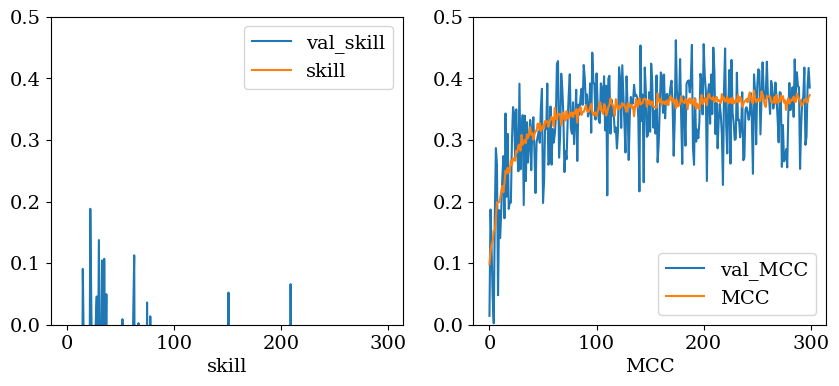

In [100]:
X_tr = MiddleT['tr'].normalized[tau:]
y_tr = np.array(list_extremes['tr'][:-tau]) # we have to remove the tail so that X and y have the same dimensions
X_va = MiddleT['va'].normalized[tau:]
y_va = np.array(list_extremes['va'][:-tau]) # we have to remove the tail so that X and y have the same dimensions

X_tr, X_va = [], []
for field in [groundT, psi, MiddleT]:
    X_tr.append(field['tr'].normalized[tau:]) 
    X_va.append(field['va'].normalized[tau:])
X_tr = np.concatenate(X_tr,axis=2)
X_va = np.concatenate(X_va,axis=2)

print(f'{X_tr.shape = }, {X_va.shape = }, {y_tr.shape = }, {y_va.shape = }')

model_input_dim = X_tr.shape[1:] #(X.shape[1],X.shape[2])
#model = create_regularized_model(1e-5, 1)
model = create_Logistic(model_input_dim, regularizer='l2', regularizer_coef=1e-9)

print("model_input_dim = ",model_input_dim)

undersampling_factor=1

tf_sampling = tf.cast([0.5*np.log(undersampling_factor), -0.5*np.log(undersampling_factor)], tf.float32)
model.summary()
#METRICS=['accuracy',MCCMetric(2),ConfusionMatrixMetric(2)]   # the last two make the code run longer but give precise discrete prediction benchmarks
METRICS=['accuracy',MCCMetric(2),ConfusionMatrixMetric(2),CustomLoss(tf_sampling)]#tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=True)]#CustomLoss()]   # the last two make the code run longer but give precise discrete prediction benchmarks
#METRICS=['loss']
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 2e-4),
    #optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #If the predicted labels are not converted to a probability distribution by the last layer of the model (using sigmoid or softmax activation functions), we need to inform these three Cross-Entropy functions by setting their from_logits = True.
    #One advantage of using sparse categorical cross-entropy is it saves storage in memory as well as time in computation because it simply uses a single integer for a class, rather than a whole one-hot vector. This works despite the fact that the neural network has an one-hot vector output  
    metrics=METRICS   # the last two make the code run longer but give precise discrete prediction benchmarks
)
model_name='test'
   
# Create a callback that saves the model's weights

ckpt_callback = make_checkpoint_callback(model_name+"/cp-{epoch:04d}.ckpt", checkpoint_every=10)
model.save_weights(checkpoint_path.format(epoch=0))


def probability_model(inputs,input_model): # This function is used to apply softmax to the output of the neural network
    x = input_model(inputs)
    outputs = layers.Softmax()(x)
    return keras.Model(inputs, outputs)
my_history=model.fit(X_tr, y_tr, batch_size=128, validation_data=(X_va,y_va), shuffle=True, callbacks=[ckpt_callback], epochs=300,verbose=2, class_weight=None)

model.save(model_name)
np.save(model_name+'_history.npy',my_history.history)

my_probability_model=(tf.keras.Sequential([ # softmax output to make a prediction
    model,
    tf.keras.layers.Softmax()
]))
percent=5
maxskill = -(percent/100.)*np.log(percent/100.)-(1-percent/100.)*np.log(1-percent/100.)
my_history.history['val_skill'] =  (maxskill-my_history.history['val_loss'])/maxskill
my_history.history['skill'] =  (maxskill-my_history.history['loss'])/maxskill
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4),constrained_layout=False)

for j, metric in enumerate(['skill','MCC']):
    axs[j].plot(my_history.history[f'val_{metric}'],label=f'val_{metric}')
    axs[j].plot(my_history.history[metric],label=metric)
    axs[j].set_xlabel(metric)
    axs[j].legend(loc='best')

axs[0].set_ylim([0,.5])
axs[1].set_ylim([0,.5])

The fact that we only get useful results with MiddleT is strange. This could change with deep neural network. Another surprising fact is that we get ok stats for MCC, but not so for the logarithmis skill.

(0.0, 0.5)

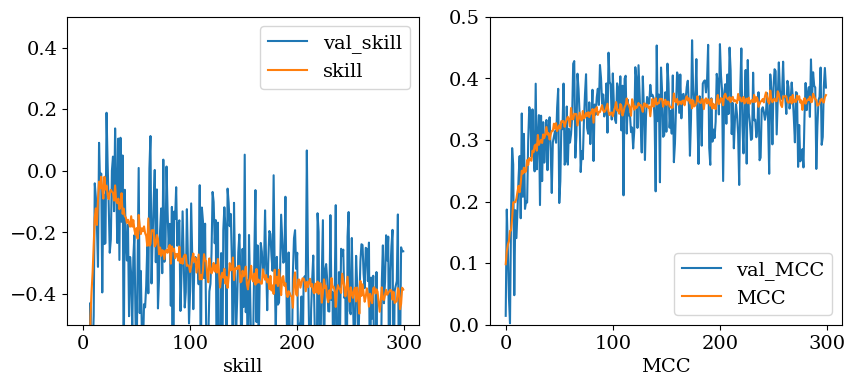

In [101]:
maxskill = -(percent/100.)*np.log(percent/100.)-(1-percent/100.)*np.log(1-percent/100.)
my_history.history['val_skill'] =  (maxskill-my_history.history['val_loss'])/maxskill
my_history.history['skill'] =  (maxskill-my_history.history['loss'])/maxskill
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4),constrained_layout=False)

for j, metric in enumerate(['skill','MCC']):
    axs[j].plot(my_history.history[f'val_{metric}'],label=f'val_{metric}')
    axs[j].plot(my_history.history[metric],label=metric)
    axs[j].set_xlabel(metric)
    axs[j].legend(loc='best')

axs[0].set_ylim([-0.5,.5])
axs[1].set_ylim([0,.5])